# Convolutional Neural Networks in hls4ml<br>
<br>
In this notebook we will use a simple convolutional neural network for e/gamma classification in nEXO experiment.<br>
<br>
The dataset is constructed with charge readout simulation of electron and gamma events with energies between 1 and 3 MeV. An electron event has a label of 1, and a gamma event has a label of 0.<br>
<br>
Each event has a size of 200\*255\*2. 

## Start with the neccessary imports

In[1]:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
import tensorflow_datasets as tfds

2023-02-22 13:51:33.847554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 13:51:33.955156: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-22 13:51:34.492828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-22 13:51:34.492881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## Load custom nEXO dataset<br>
<br>
In this part we will fetch the trainining, validation and test dataset using a custom dataloader to load nEXO dataset.

In[2]:

In [2]:
n_classes = 2
input_shape = [200, 255, 2]
batch_size = 60
from data_loader import nEXODataset
from tensorflow.data import Dataset
csv_train = '/scratch/zel032/DatasetFromMin/nexo_train.csv'
csv_test = '/scratch/zel032/DatasetFromMin/nexo_valid.csv'
h5file = '/scratch/zel032/DatasetFromMin/nexo.h5'
# load dataset
train_dg = nEXODataset('train',h5file,csv_train)
test_dg = nEXODataset('test',h5file,csv_test)
train_ds = Dataset.from_generator(train_dg, output_types = (tf.float32, tf.int64) , output_shapes = (tf.TensorShape(input_shape),tf.TensorShape([])))
test_ds = Dataset.from_generator(test_dg, output_types = (tf.float32, tf.int64) , output_shapes = (tf.TensorShape(input_shape),tf.TensorShape([])))
train_ds = train_ds.interleave(lambda x, y: tf.data.Dataset.from_tensors((x,y)), cycle_length=4, block_length=16)
test_ds = test_ds.interleave(lambda x, y: tf.data.Dataset.from_tensors((x,y)), cycle_length=4, block_length=16)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-22 13:51:37.103046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-02-22 13:51:37.103076: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-22 13:51:37.103363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In[3]:

In [3]:
def preprocess(image, label,nclasses=2):
    #image = tf.cast(image, tf.float32) / 256.
    label = tf.one_hot(tf.squeeze(label), nclasses)
    print(image.shape, label.shape, type(label))
    return image, label
train_data = train_ds.map(preprocess,n_classes) #Get dataset as image and one-hot encoded labels, divided by max RGB   
train_data = train_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
for example in train_data.take(1):
    break
print("X train batch shape = {}, Y train batch shape = {} ".format(example[0].shape, example[1].shape))
val_data = test_ds.map(preprocess,n_classes)    
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)

(200, 255, 2) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
X train batch shape = (60, 200, 255, 2), Y train batch shape = (60, 2) 
(200, 255, 2) (2,) <class 'tensorflow.python.framework.ops.Tensor'>


In[4]:

## Defining the model<br>
<br>
We then need to define a model. For the lowest possible latency, each layer should have a maximum number of trainable parameters of 4096. This is due to fixed limits in the Vivado compiler, beyond which maximally unrolled (=parallel) compilation will fail. This will allow us to use `strategy = 'latency'` in the hls4ml part, rather than `strategy = 'resource'`, in turn resulting in lower latency

In[5]:

In [4]:
import resnet_v1_eembc
kwargs = {'input_shape': input_shape,
            'num_classes': n_classes,
            'avg_pooling': True 
        }
model_name = 'resnet_v1_eembc'
#model = getattr(resnet_v1_eembc, model_name)(**kwargs)
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model
filters_per_conv_layer = [16,16,24]
neurons_per_dense_layer = [42,64]
x = x_in = Input(input_shape)

for i,f in enumerate(filters_per_conv_layer):
    print( ('Adding convolutional block {} with N={} filters').format(i,f) )
    x = Conv2D(int(f), kernel_size=(3,3), strides=(1,1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), use_bias=False,
               name='conv_{}'.format(i))(x) 
    x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
    x = Activation('relu',name='conv_act_%i'%i)(x)
    x = MaxPooling2D(pool_size = (2,2),name='pool_{}'.format(i) )(x)
x = Flatten()(x)

for i,n in enumerate(neurons_per_dense_layer):
    print( ('Adding dense block {} with N={} neurons').format(i,n) )
    x = Dense(n,kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001),name='dense_%i'%i, use_bias=False)(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = Activation('relu',name='dense_act_%i'%i)(x)
x = Dense(int(n_classes),name='output_dense')(x)
x_out = Activation('softmax',name='output_softmax')(x)

model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

model.summary()

Adding convolutional block 0 with N=16 filters
Adding convolutional block 1 with N=16 filters
Adding convolutional block 2 with N=24 filters
Adding dense block 0 with N=42 neurons
Adding dense block 1 with N=64 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 255, 2)]     0         
                                                                 
 conv_0 (Conv2D)             (None, 198, 253, 16)      288       
                                                                 
 bn_conv_0 (BatchNormalizati  (None, 198, 253, 16)     64        
 on)                                                             
                                                                 
 conv_act_0 (Activation)     (None, 198, 253, 16)      0         
                                                                 
 pool_0 (MaxPooling2D)       (N

Lets check if this model can be implemented completely unrolled (=parallel)

In[6]:

In [5]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name,layersize)) # 0 = weights, 1 = biases
        if (layersize > 4096): # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name,layersize))

conv_0: 288
conv_1: 2304
conv_2: 3456
dense_0: 695520
Layer dense_0 is too large (695520), are you sure you want to train?
dense_1: 2688
output_dense: 128


Looks good! It's below the Vivado-enforced unroll limit of 4096.<br>
<br>
## Prune dense and convolutional layers<br>
Since we've seen in the previous notebooks that pruning can be done at no accuracy cost, let's prune the convolutional and dense layers to 50% sparsity, skipping the output layer

In[7]:

In [6]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
NSTEPS = 180000  // batch_size #90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))
def pruneFunction(layer):
    pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = 0.0,
                                                                   final_sparsity = 0.50, 
                                                                   begin_step = NSTEPS*2, 
                                                                   end_step = NSTEPS*10, 
                                                                   frequency = NSTEPS)
                     }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name!='output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)  
    return layer
model_pruned = tf.keras.models.clone_model( model , clone_function=pruneFunction)

Number of training steps per epoch is 3000


## Train baseline<br>
<br>
We're now ready to train the model! We defined the batch size and n epochs above. We won't use callbacks that store the best weights only, since this might select a weight configuration that has not yet reached 50% sparsity.

In[8]:

In [7]:
train = True # True if you want to retrain, false if you want to load a previsously trained model
n_epochs = 1
if train:
    
    LOSS        = tf.keras.losses.BinaryCrossentropy()
    OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=3E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])
    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            pruning_callbacks.UpdatePruningStep()
            ] 
    start = time.time()
    model_pruned.fit(train_data,
                     epochs = n_epochs,
                     validation_data = val_data,
                     callbacks = callbacks)   
    end = time.time()
    print('It took {} minutes to train Keras model'.format( (end - start)/60.))
    
    model_pruned.save('pruned_cnn_model.h5')
else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    
    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)

3237/3237 [==============================] - 1984s 612ms/step - loss: 0.5997 - accuracy: 0.8020 - val_loss: 0.6858 - val_accuracy: 0.6393 - lr: 0.0030
It took 33.074965663750966 minutes to train Keras model


## Quantization and the fused Conv2D+BatchNormalization layer in QKeras<br>
Let's now create a pruned an quantized model using QKeras. For this, we will use a fused Convolutional and BatchNormalization (BN) layer from QKeras, which will further speed up the implementation when we implement the model using hls4ml. <br>
There is currently no fused Dense+BatchNoralization layer available in QKeras, so we'll use Keras BatchNormalization when BN follows a Dense layer for now. We'll use the same precision everywhere, namely a bit width of 6 and 0 integer bits (this will be implemented as``<6,1>`` in hls4ml, due to the missing sign-bit). For now, make sure to set ```use_bias=True``` in ```QConv2DBatchnorm``` to avoid problems during synthesis.

In[11]:

In [8]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm
kwargs = {'input_shape': input_shape,
          'num_classes': n_classes,
          'avg_pooling': True,
          'logit_total_bits': 10,
          'logit_int_bits': 4,
          'activation_total_bits': 16,
          'activation_int_bits':12
        }
model_name = 'resnet_v1_eembc_quantized'
#qmodel = getattr(resnet_v1_eembc, model_name)(**kwargs)
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm

x = x_in = Input(shape=input_shape)

for i,f in enumerate(filters_per_conv_layer):
    print( ('Adding fused QConv+BN block {} with N={} filters').format(i,f) )
    x = QConv2DBatchnorm(int(f), kernel_size=(3,3), strides=(1,1),
                         kernel_quantizer="quantized_bits(6,0,alpha=1)", 
                         bias_quantizer="quantized_bits(6,0,alpha=1)",
                         kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), use_bias=True,
                         name='fused_convbn_{}'.format(i))(x) 
    x = QActivation('quantized_relu(6)',name='conv_act_%i'%i)(x)
    x = MaxPooling2D(pool_size = (2,2),name='pool_{}'.format(i) )(x)
x = Flatten()(x)

for i,n in enumerate(neurons_per_dense_layer):
    print( ('Adding QDense block {} with N={} neurons').format(i,n) )
    x = QDense(n,
            kernel_quantizer="quantized_bits(6,0,alpha=1)",
            kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001),name='dense_%i'%i, use_bias=False)(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = QActivation('quantized_relu(6)',name='dense_act_%i'%i)(x)
x = Dense(int(n_classes),
           name='output_dense')(x)
x_out = Activation('softmax',name='output_softmax')(x)
qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

qmodel.summary()

Adding fused QConv+BN block 0 with N=16 filters
Adding fused QConv+BN block 1 with N=16 filters
Adding fused QConv+BN block 2 with N=24 filters
Adding QDense block 0 with N=42 neurons
Adding QDense block 1 with N=64 neurons
Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 255, 2)]     0         
                                                                 
 fused_convbn_0 (QConv2DBatc  (None, 198, 253, 16)     369       
 hnorm)                                                          
                                                                 
 conv_act_0 (QActivation)    (None, 198, 253, 16)      0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 99, 126, 16)       0         
                                                                 
 fused_convbn_1 (QConv2DBatc  (Non

/home/zel032/software/miniconda3/envs/hls4ml/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In[12]:

Print the quantized layers

In [9]:
from qkeras.autoqkeras.utils import print_qmodel_summary
print_qmodel_summary(qmodel)        

fused_convbn_0       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_0           quantized_relu(6)
fused_convbn_1       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_1           quantized_relu(6)
fused_convbn_2       f=24 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_2           quantized_relu(6)
dense_0              u=42 quantized_bits(6,0,0,alpha=1) 
bn_dense_0           is normal keras bn layer
dense_act_0          quantized_relu(6)
dense_1              u=64 quantized_bits(6,0,0,alpha=1) 
bn_dense_1           is normal keras bn layer
dense_act_1          quantized_relu(6)



You see that a bias quantizer is defined, although we are not using a bias term for the layers. This is set automatically by QKeras. In addition, you'll note that ``alpha='1'``. This sets the weight scale per channel to 1 (no scaling). The default is ``alpha='auto_po2'``, which sets the weight scale per channel to be a power-of-2, such that an actual hardware implementation can be performed by just shifting the result of the convolutional/dense layer to the right or left by checking the sign of the scale and then taking the log2 of the scale.<br>
<br>
Let's now prune and train this model! If you want, you can also train the unpruned version, ``qmodel`` and see how the performance compares. We will stick to the pruned one here. Again, we do not use a model checkpoint which stores the best weights, in order to ensure the model is trained to the desired sparsity.

In[13]:

In [10]:
qmodel_pruned = tf.keras.models.clone_model( qmodel, clone_function=pruneFunction)

In[14]:

In [11]:
train = False
if train:
    LOSS        = tf.keras.losses.BinaryCrossentropy()
    OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=1E-2, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True) 
    qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])
    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            pruning_callbacks.UpdatePruningStep()
            ]  
    start = time.time()
    history = qmodel_pruned.fit(train_data,
                          epochs = n_epochs,
                          validation_data = val_data,
                          callbacks = callbacks, 
                          verbose=1)     
    end = time.time()
    print('\n It took {} minutes to train!\n'.format( (end - start)/60.))
    qmodel_pruned.save('quantized_pruned_cnn_model.h5')
else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    
    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    qmodel_pruned = tf.keras.models.load_model('quantized_pruned_cnn_model.h5', custom_objects=co)

We note that training a model quantization aware, takes around twice as long as when not quantizing during training!<br>
The validation accuracy is very similar to that of the floating point model equivalent, despite containing significantly less information <br>
<br>
## Performance<br>
Let's look at some ROC curves to compare the performance. Lets choose a few numbers so it doesn't get confusing. Feel free to change the numbers in ``labels``.

In[15]:

For  testing, we get the full dataset in memory as it's rather small.<br>
We fetch it as numpy arrays to have access to labels and images separately

In [12]:
iterator = iter(val_data)
X_test, Y_test = next(iterator)
#X_test, Y_test = tfds.as_numpy(val_data)
#X_test, Y_test = preprocess(X_test, Y_test,nclasses=n_classes)
print("X test batch shape = {}, Y test batch shape = {} ".format(X_test.shape,Y_test.shape))
#iterator = iter(val_data)
#X_test, Y_test = val_data #next(iterator)
#X_test, Y_test = preprocess(X_test, Y_test,nclasses=n_classes)
predict_baseline    = model_pruned.predict(X_test)
#print(predict_baseline)
test_score_baseline = model_pruned.evaluate(X_test, Y_test)
predict_qkeras    = qmodel_pruned.predict(X_test)
print(predict_qkeras)
test_score_qkeras = qmodel_pruned.evaluate(X_test, Y_test)
print('Keras accuracy = {} , QKeras 6-bit accuracy = {}'.format(test_score_baseline[1],test_score_qkeras[1]))

X test batch shape = (60, 200, 255, 2), Y test batch shape = (60, 2) 
2/2 [==============================] - 0s 14ms/step - loss: 0.6190 - accuracy: 0.7167


ValueError: in user code:

    File "/home/zel032/software/miniconda3/envs/hls4ml/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/home/zel032/software/miniconda3/envs/hls4ml/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/zel032/software/miniconda3/envs/hls4ml/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/home/zel032/software/miniconda3/envs/hls4ml/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/home/zel032/software/miniconda3/envs/hls4ml/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/zel032/software/miniconda3/envs/hls4ml/lib/python3.8/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "qkeras" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 200, 255, 2)


In[19]:

Plotting ROC for labels ['0', '1']


NameError: name 'predict_qkeras' is not defined

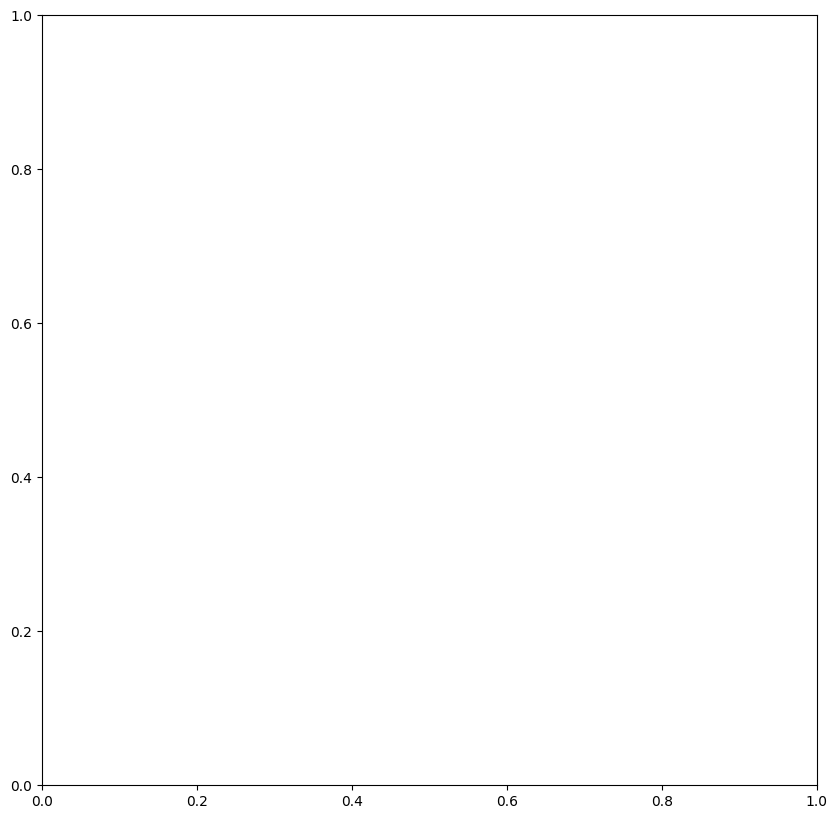

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
labels=['%i'%nr for nr in range (0,n_classes)] # If you want to look at all the labels
# labels = ['0','1','9'] # Look at only a few labels, here for digits 0, 1 and 9
print('Plotting ROC for labels {}'.format(labels))
df = pd.DataFrame()
df_q = pd.DataFrame()
fpr  = {}
tpr  = {}
auc1 = {}
fpr_q  = {}
tpr_q  = {}
auc1_q = {}
#get_ipython().run_line_magic('matplotlib', 'inline')
colors  = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
fig, ax = plt.subplots(figsize=(10, 10))
for i, label in enumerate(labels):
    df[label] =  Y_test[:,int(label)]
    df[label + '_pred'] = predict_baseline[:,int(label)]
    fpr[label], tpr[label], threshold = metrics.roc_curve(df[label],df[label+'_pred'])
    auc1[label] = metrics.auc(fpr[label], tpr[label])
    
    df_q[label] = Y_test[:,int(label)]
    df_q[label + '_pred'] = predict_qkeras[:,int(label)]
    fpr_q[label], tpr_q[label], threshold_q = metrics.roc_curve(df_q[label],df_q[label+'_pred'])
    auc1_q[label] = metrics.auc(fpr_q[label], tpr_q[label])
    
    plt.plot(fpr[label],tpr[label]    ,label=r'{}, AUC Keras = {:.1f}% AUC QKeras = {:.1f}%)'.format(label,auc1[label]*100,auc1_q[label]*100), linewidth=1.5,c=colors[i],linestyle='solid')
    plt.plot(fpr_q[label],tpr_q[label], linewidth=1.5,c=colors[i],linestyle='dotted')
plt.semilogx()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(0.01,1.)
plt.ylim(0.5,1.1)
plt.legend(loc='lower right')
#plt.figtext(0.2, 0.83,r'Accuracy Keras = {:.1f}% QKeras 8-bit = {:.1f}%'.format(test_score_baseline[1]*100,test_score_qkeras[1]*100), wrap=True, horizontalalignment='left',verticalalignment='center')
from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['Keras', 'QKeras'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

The difference in AUC between the fp32 Keras model and the 8-bit QKeras model, is small, as we have seen for the previous examples. You can find a bonus exercise below, **Bonus: Automatic quantization**, where we'll use AutoQKeras to find the best heterogeneously quantized model, given a set of resource and accuracy constriants.<br>
### Check sparsity<br>
Let's also check the per-layer sparsity:

In[20]:

Layer prune_low_magnitude_conv_0: % of zeros = 0.0
Layer bn_conv_0: % of zeros = 0.0
Layer prune_low_magnitude_conv_1: % of zeros = 0.0
Layer bn_conv_1: % of zeros = 0.0
Layer prune_low_magnitude_conv_2: % of zeros = 0.0
Layer bn_conv_2: % of zeros = 0.0
Layer prune_low_magnitude_dense_0: % of zeros = 0.0
Layer bn_dense_0: % of zeros = 0.0
Layer prune_low_magnitude_dense_1: % of zeros = 0.0
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0
Layer prune_low_magnitude_fused_convbn_0: % of zeros = 0.5
Layer prune_low_magnitude_fused_convbn_1: % of zeros = 0.5
Layer prune_low_magnitude_fused_convbn_2: % of zeros = 0.5
Layer prune_low_magnitude_dense_0: % of zeros = 0.5
Layer bn_dense_0: % of zeros = 0.0
Layer prune_low_magnitude_dense_1: % of zeros = 0.5
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0


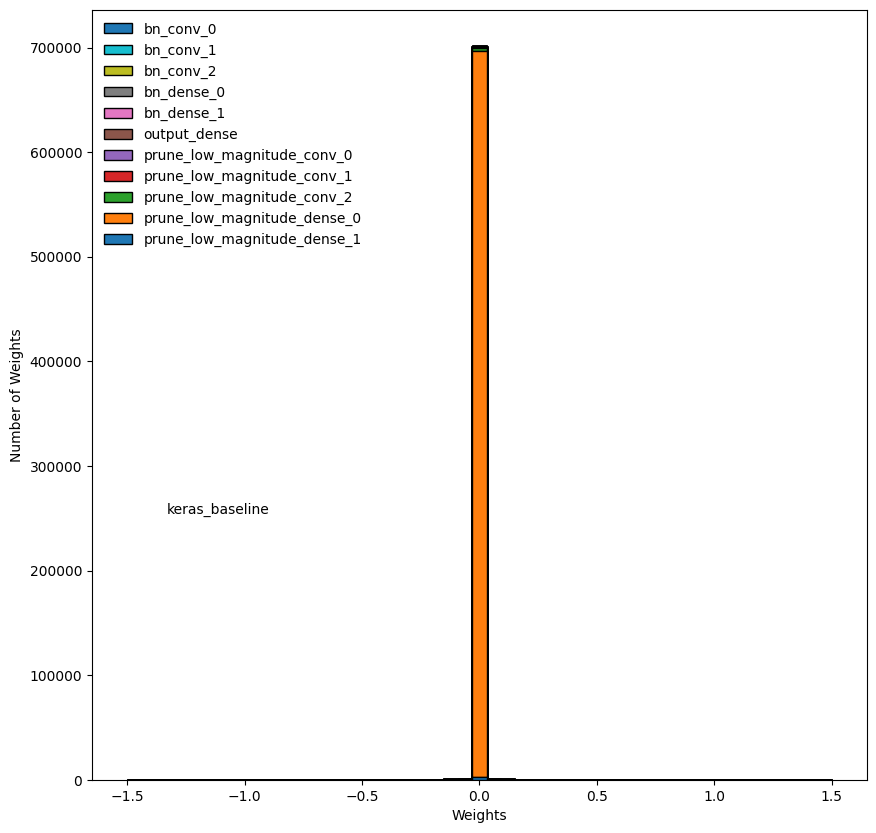

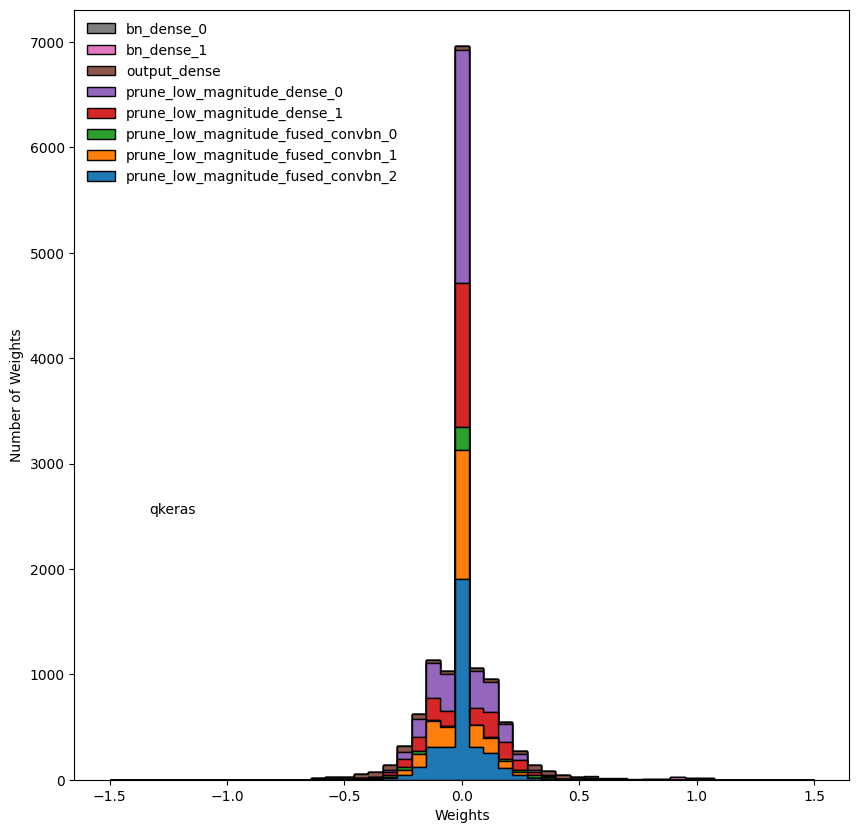

In [14]:
def doWeights(model):
    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch")!=-1 or len(layer.get_weights())<1:
            continue 
        weights=layer.weights[0].numpy().flatten()  
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name,np.sum(weights==0)/np.size(weights)))
    labelsW = []
    histosW = []
    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])
    fig = plt.figure(figsize=(10,10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW,bins,histtype='stepfilled',stacked=True,label=labelsW, edgecolor='black')
    plt.legend(frameon=False,loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38,model._name, wrap=True, horizontalalignment='left',verticalalignment='center')
    
doWeights(model_pruned) 
doWeights(qmodel_pruned) 

We see that 50% of the weights per layer are set to zero, as expected.<br>
Now, let's synthesize the floating point Keras model and the QKeras quantized model!

## CNNs in hls4ml<br>
<br>
In this part, we will take the two models we trained above (the floating-point 32 Keras model and the 6-bit QKeras model), and synthesize them with hls4ml. Although your models are probably already in memory, let's load them from scratch. We need to pass the appropriate custom QKeras/pruning layers when loading, and remove the pruning parameters that were saved together with the model.

In[21]:

In [15]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from qkeras.utils import _add_supported_quantized_objects

In [16]:
co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

In [17]:
model = tf.keras.models.load_model('pruned_cnn_model.h5',custom_objects=co)
model  = strip_pruning(model)

In [18]:
qmodel = tf.keras.models.load_model('quantized_pruned_cnn_model.h5',custom_objects=co)
qmodel  = strip_pruning(qmodel)

Now, we need to define the hls4ml and Vivado configurations. Two things will change with respect to what was done in the previous exercises. First, we will use ``IOType= 'io_stream'`` in the Vivado configuration.<br>
<br>
---<br>
****You must use ``IOType= 'io_stream'`` if attempting to synthesize a convolutional neural network.****<br>
<br>
---<br>
The CNN implementation in hls4ml is based on streams, which are synthesized in hardware as first in, first out (FIFO) buffers. Shift registers are used to keep track of the last  ``<kernel height - 1>`` rows of input pixels, and maintains a shifting snapshot of the convolution kernel.<br>
<br>
This is illustrated  in the gif below. Here, the input image is at the top-left and the output image at the bottom left. The top right image shows the internal state of the shift registers and convolutional kernel. The red square indicates the current pixels contained within the convolutional kernel.<br>
<br>
![alt text](images/conv2d_animation.gif "The implementation of convolutional layers in hls4ml.")<br>
<br>
Lastly, we will use ``['Strategy'] = 'Latency'`` for all the layers in the hls4ml configuration. If one layer would have >4096 elements, we sould set ``['Strategy'] = 'Resource'`` for that layer, or increase the reuse factor by hand. You can find examples of how to do this below.

In[23]:

In [19]:
import hls4ml
import plotting

/home/zel032/software/miniconda3/envs/hls4ml/lib/python3.8/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [20]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

irst, the baseline model

In [21]:
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: conv_0, layer type: Conv2D
  -> Activation (linear), layer name: conv_0
Layer name: bn_conv_0, layer type: BatchNormalization
Layer name: conv_act_0, layer type: Activation
Layer name: pool_0, layer type: MaxPooling2D
Layer name: conv_1, layer type: Conv2D
  -> Activation (linear), layer name: conv_1
Layer name: bn_conv_1, layer type: BatchNormalization
Layer name: conv_act_1, layer type: Activation
Layer name: pool_1, layer type: MaxPooling2D
Layer name: conv_2, layer type: Conv2D
  -> Activation (linear), layer name: conv_2
Layer name: bn_conv_2, layer type: BatchNormalization
Layer name: conv_act_2, layer type: Activation
Layer name: pool_2, layer type: MaxPooling2D
Layer name: dense_0, layer type: Dense
  -> Activation (linear), layer name: dense_0
Layer name: bn_dense_0, layer type: BatchNormalization
Layer name: dense_act_0, layer type: Activation
Layer name: dense_1, layer type: Dense
  -> Activation

Set the precision and reuse factor for the full model

In [22]:
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource' <br>
or increase the reuse factor individually for large layers.<br>
In this case, we designed the model to be small enough for a fully parallel implementation <br>
so we use the latency strategy and reuse factor of 1 for all layers.

In [23]:
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
    hls_config['LayerName'][Layer]['Trace'] = True
#If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
#hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  input_1
    Precision
      result:        ap_fixed<16,6>
    Strategy:        Latency
    ReuseFactor:     1
    Trace:           True
  conv_0
    Precision
      weight:        ap_fixed<16,6>
      bias:          ap_fixed<16,6>
      result:        ap_fixed<16,6>
    ReuseFactor:     1
    Strategy:        Latency
    Trace:           True
  conv_0_linear
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    table_t:         ap_fixed<18,8>
    Strategy:        Latency
    Trace:           True
  bn_conv_0
    Precision
      scale:         ap_fixed<16,6>
      bias:          ap_fixed<16,6>
    ReuseFactor:     1
    Strategy:        Latency
    Trace:           True
  conv_act_0
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    table_t:         ap_fixed<18,8>
    Strategy:        Latency
    Trace:        

In [24]:
cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config
cfg['KerasModel'] = model
cfg['OutputDir']  = 'pruned_cnn/'
cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'
  
hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 200, 255, 2]], output shape: [None, 200, 255, 2]
Layer name: conv_0, layer type: Conv2D, input shapes: [[None, 200, 255, 2]], output shape: [None, 198, 253, 16]
Layer name: bn_conv_0, layer type: BatchNormalization, input shapes: [[None, 198, 253, 16]], output shape: [None, 198, 253, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 198, 253, 16]], output shape: [None, 198, 253, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 198, 253, 16]], output shape: [None, 99, 126, 16]
Layer name: conv_1, layer type: Conv2D, input shapes: [[None, 99, 126, 16]], output shape: [None, 97, 124, 16]
Layer name: bn_conv_1, layer type: BatchNormalization, input shapes: [[None, 97, 124, 16]], output shape: [None, 97, 124, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 97, 124, 16]], output shape: [None, 97, 124, 16]
Layer name: pool_1, 

Done


firmware/myproject.cpp: In function ‘void myproject(hls::stream<nnet::array<ap_fixed<16, 6>, 2> >&, hls::stream<nnet::array<ap_fixed<16, 6>, 2> >&, short unsigned int&, short unsigned int&)’:
firmware/myproject.cpp:35:46: warning: unsigned conversion from ‘int’ to ‘short unsigned int’ changes value from ‘102000’ to ‘36464’ [-Woverflow]
     const_size_in_1 = N_INPUT_1_1*N_INPUT_2_1*N_INPUT_3_1;


Let's get a nice overview over the various shapes and precisions used for each layer through ``hls4ml.utils.plot_model``, as well as look at the weight profile using ``hls4ml.model.profiling.numerical``. The weight profiling returns two plots: Before (top) and after (bottom) various optimizations applied to the HLS model before the final translation to HLS, for instance the fusing of Dense and BatchNormalization layers.

In[24]:

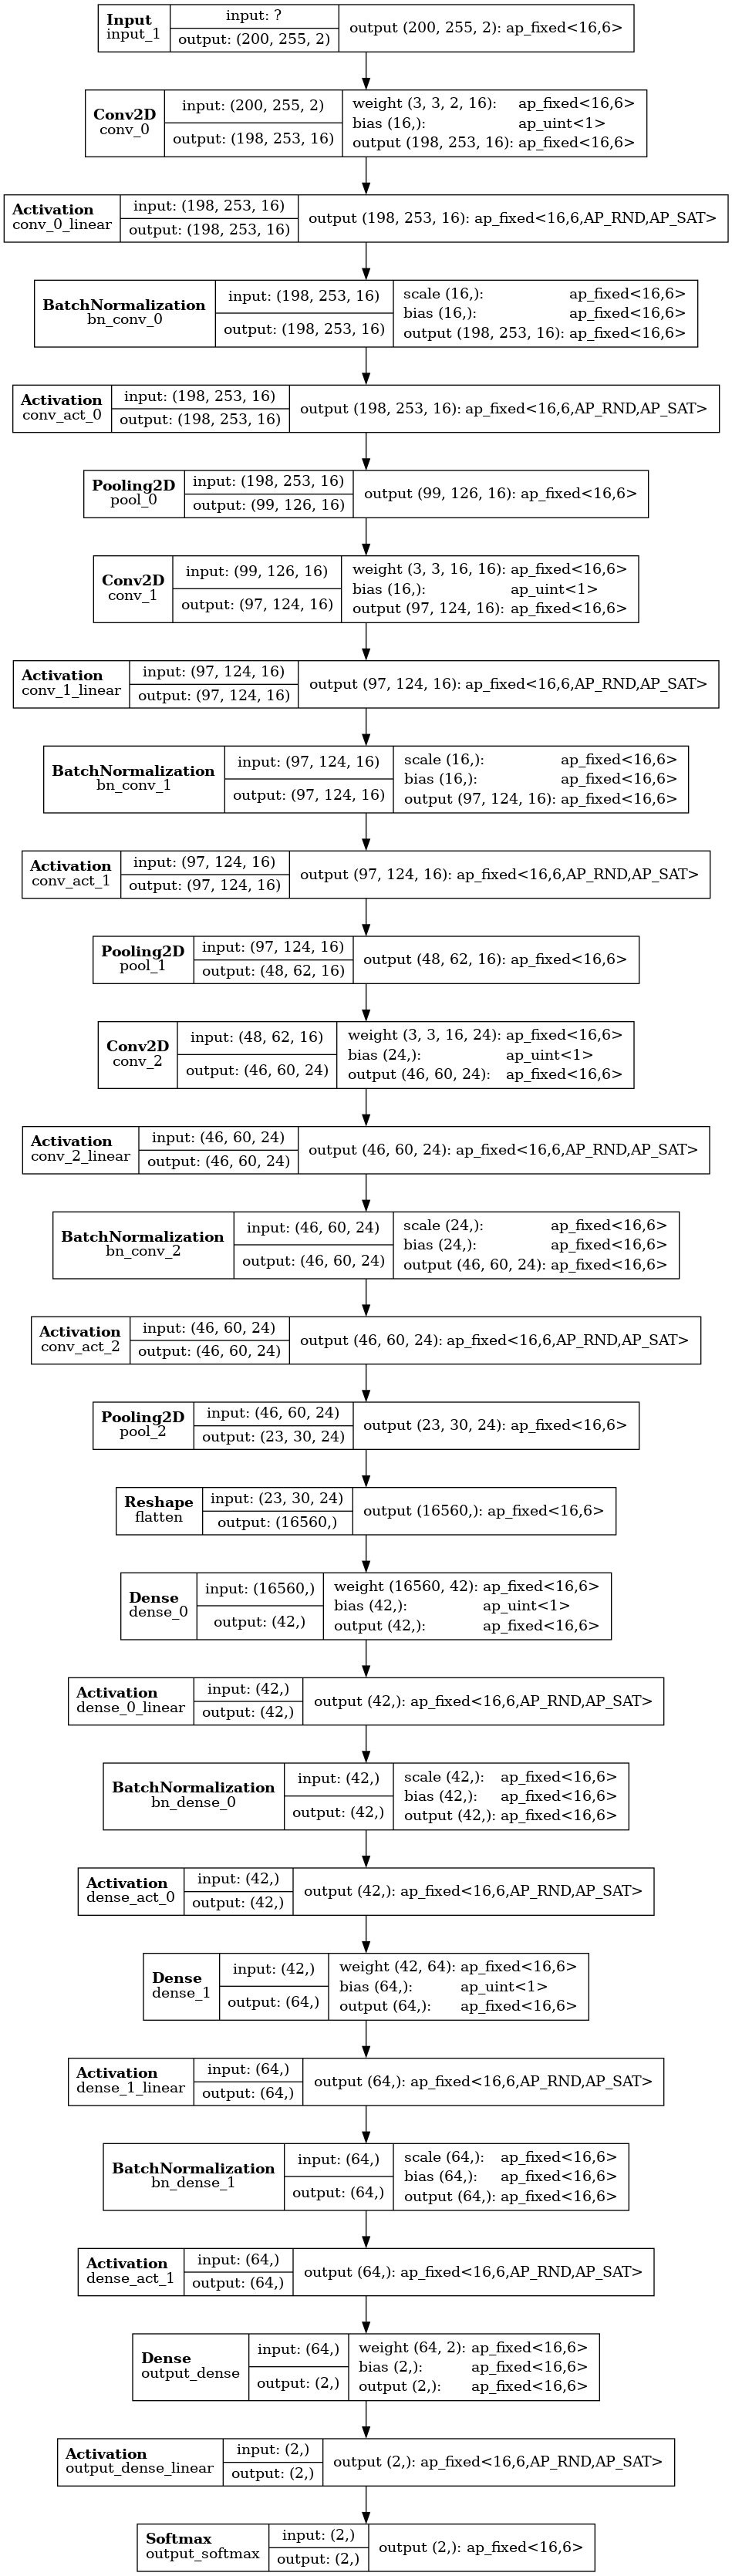

In [25]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In[25]:

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 200, 255, 2]], output shape: [None, 200, 255, 2]
Layer name: conv_0, layer type: Conv2D, input shapes: [[None, 200, 255, 2]], output shape: [None, 198, 253, 16]
Layer name: bn_conv_0, layer type: BatchNormalization, input shapes: [[None, 198, 253, 16]], output shape: [None, 198, 253, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 198, 253, 16]], output shape: [None, 198, 253, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 198, 253, 16]], output shape: [None, 99, 126, 16]
Layer name: conv_1, layer type: Conv2D, input shapes: [[None, 99, 126, 16]], output shape: [None, 97, 124, 16]
Layer name: bn_conv_1, layer type: BatchNormalization, input shapes: [[None, 97, 124, 16]], output shape: [None, 97, 124, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 97, 124, 16]], output shape: [None, 97, 124, 16]
Layer name: pool_1, 

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

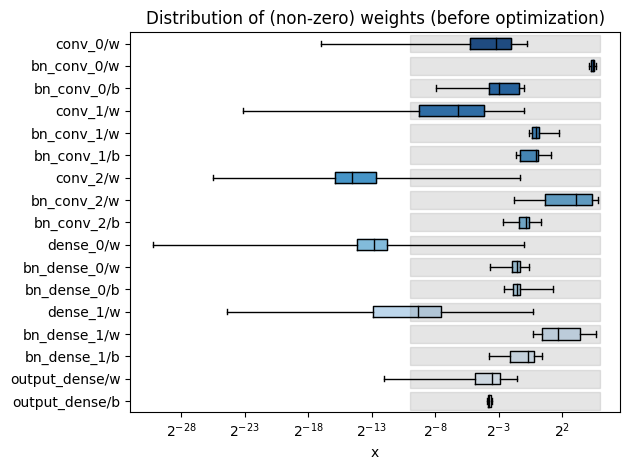

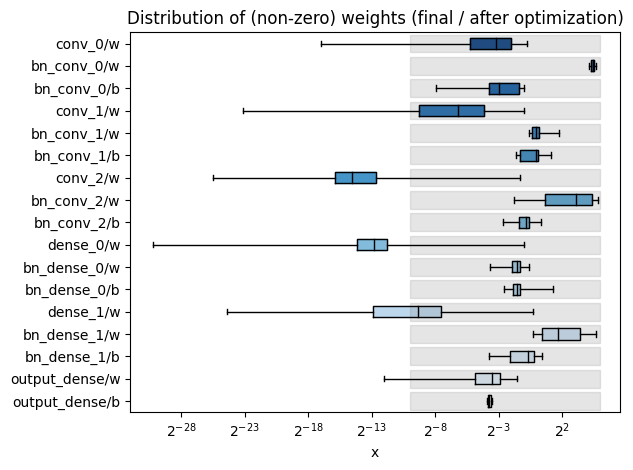

In [27]:
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model)

The colored boxes are the distribution of the weights of the model, and the gray band illustrates the numerical range covered by the chosen fixed point precision. As we configured, this model uses a precision of ``ap_fixed<16,6>`` for all layers of the model. Let's now build our QKeras model

In[27]:

Then the QKeras model

In [28]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

In [29]:
hls_config_q = hls4ml.utils.config_from_keras_model(qmodel, granularity='name')
hls_config_q['Model']['ReuseFactor'] = 1
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
#hls_config_q['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config_q)
  
cfg_q = hls4ml.converters.create_config(backend='Vivado')
cfg_q['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg_q['HLSConfig']  = hls_config_q
cfg_q['KerasModel'] = qmodel
cfg_q['OutputDir']  = 'quantized_pruned_cnn/'
cfg_q['XilinxPart'] = 'xcu250-figd2104-2L-e'
  
hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls_model_q.compile()

Interpreting Model
Topology:
Layer name: input_2, layer type: Input
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm
Layer name: conv_act_0, layer type: QActivation
Layer name: pool_0, layer type: MaxPooling2D
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm
Layer name: conv_act_1, layer type: QActivation
Layer name: pool_1, layer type: MaxPooling2D
Layer name: fused_convbn_2, layer type: QConv2DBatchnorm
Layer name: conv_act_2, layer type: QActivation
Layer name: pool_2, layer type: MaxPooling2D
Layer name: dense_0, layer type: QDense
Layer name: bn_dense_0, layer type: BatchNormalization
Layer name: dense_act_0, layer type: QActivation
Layer name: dense_1, layer type: QDense
Layer name: bn_dense_1, layer type: BatchNormalization
Layer name: dense_act_1, layer type: QActivation
Layer name: output_dense, layer type: Dense
  -> Activation (linear), layer name: output_dense
Layer name: output_softmax, layer type: Activation
Model
  Precision:         ap_fixed<16,6>
  Reus

Done


Let's plot the model and profile the weights her too

In[28]:

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 32, 32, 3]], output shape: [None, 30, 30, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 30, 30, 16]], output shape: [None, 30, 30, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 30, 30, 16]], output shape: [None, 15, 15, 16]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 15, 15, 16]], output shape: [None, 13, 13, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 13, 13, 16]], output shape: [None, 13, 13, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 6, 6, 16]
Layer name: fused_convbn_2, layer type: QConv2DBatchnorm, input shapes: [[None, 6, 6, 16]], output shape: [None, 4, 4, 24]
Layer name: conv_act_

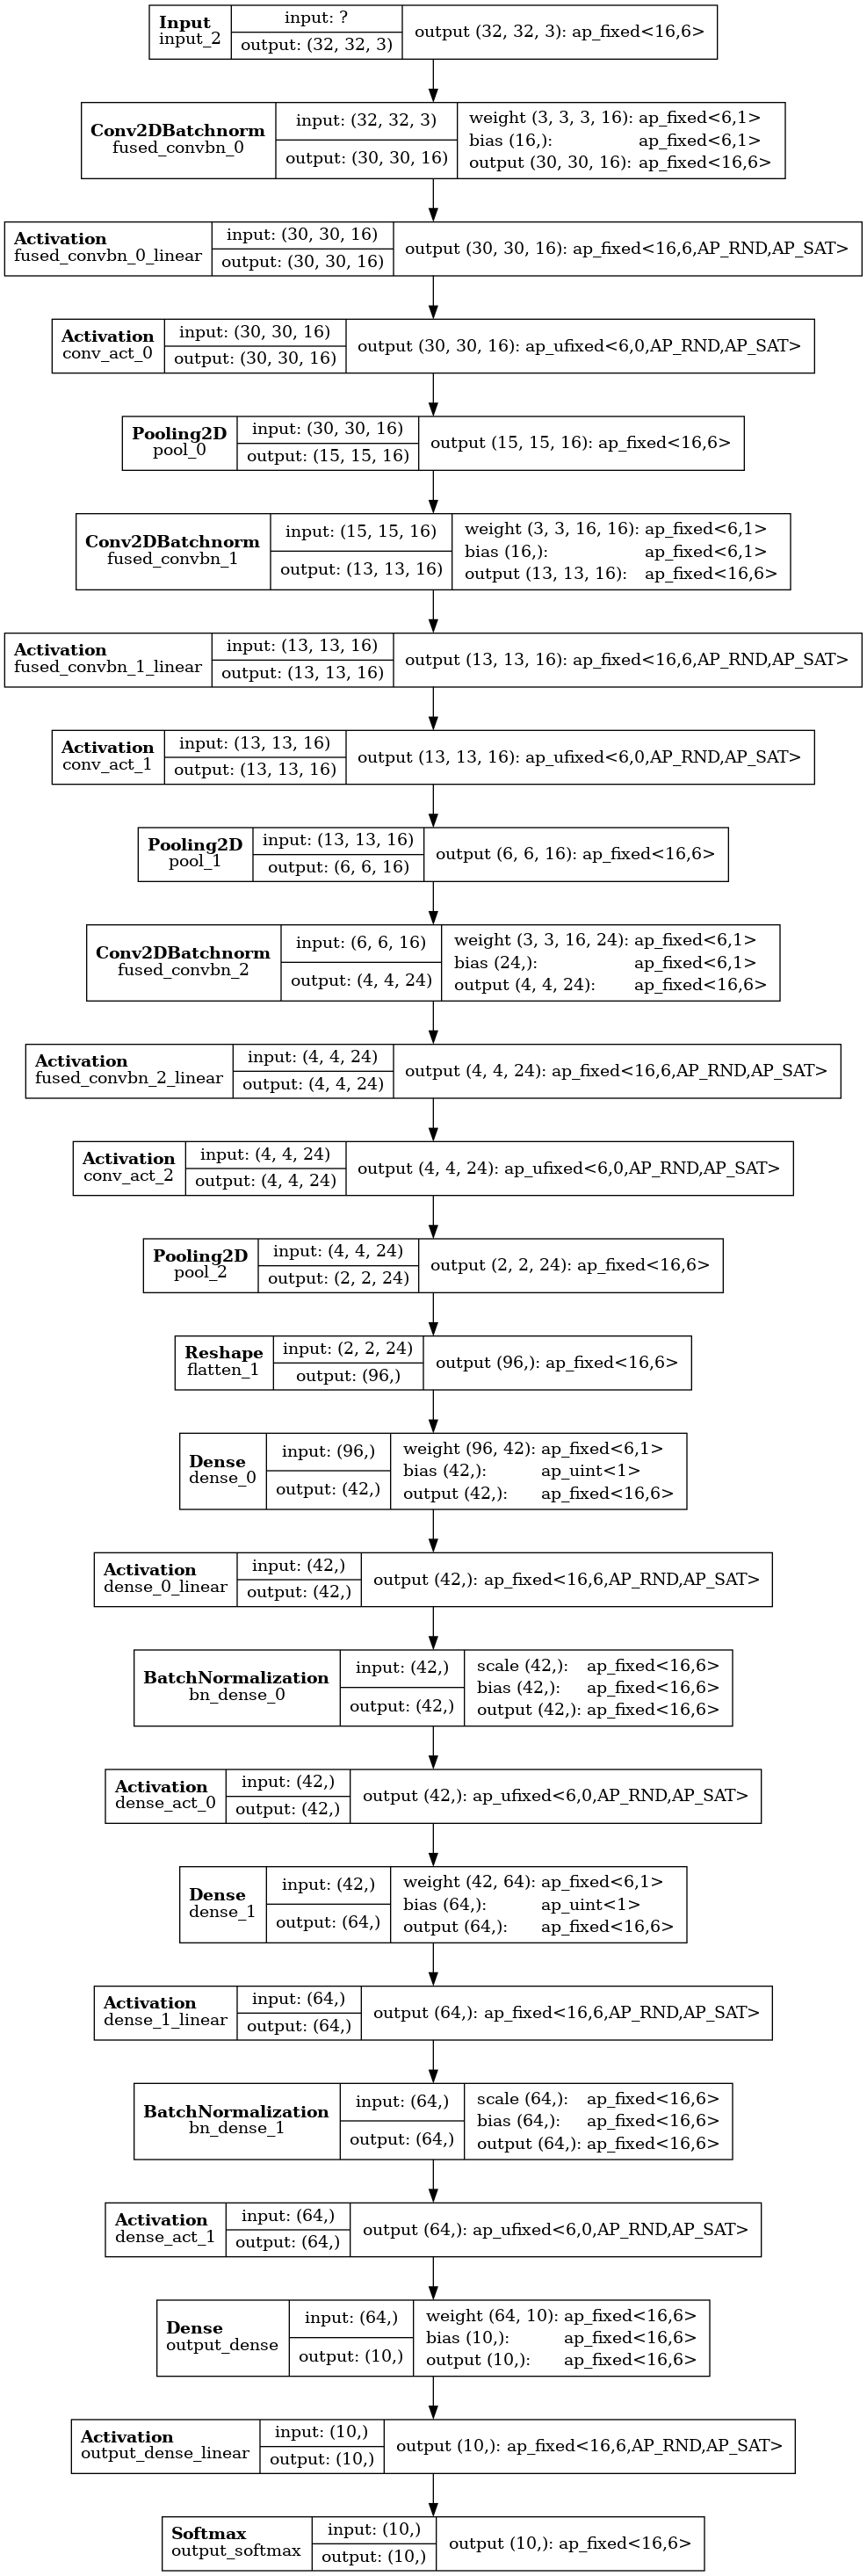

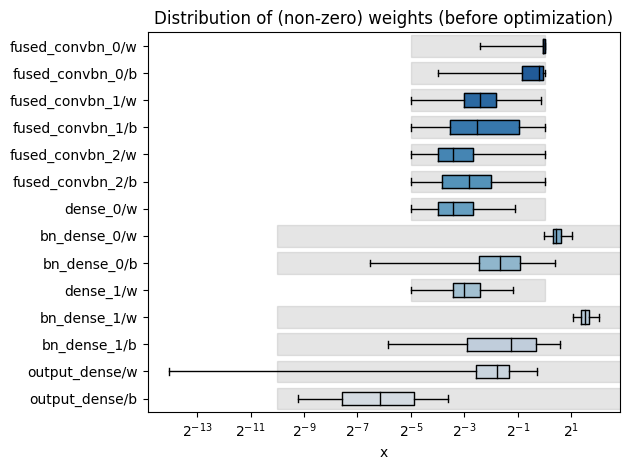

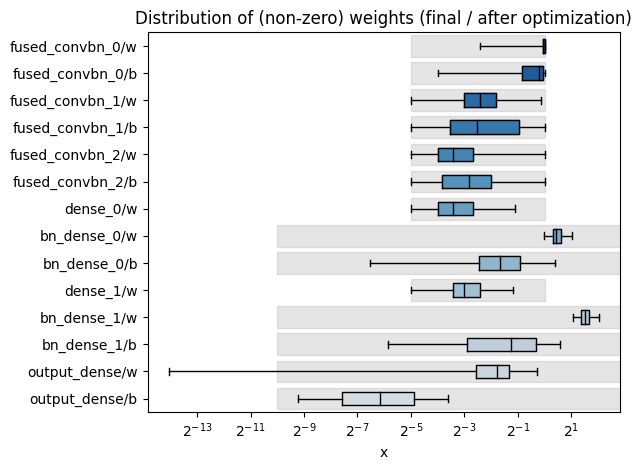

In [30]:
hls4ml.model.profiling.numerical(model=qmodel, hls_model=hls_model_q)
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None)

For the 6-bit QKeras model, we see that different precisions are used for different layers.

### Accuracy with bit-accurate emulation <br>
Let's check that the hls4ml accuracy matches the original. This usually takes some time, so let's do it over a reduced dataset

In[30]:

In [31]:
X_test_reduced = X_test[:120]
Y_test_reduced = Y_test[:120]

In [32]:
hls4ml_pred, hls4ml_trace = hls_model.trace(np.ascontiguousarray(X_test[:100]))
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model_pruned, X_test[:100])

Recompiling myproject with tracing
Writing HLS project


Done


firmware/myproject.cpp: In function ‘void myproject(hls::stream<nnet::array<ap_fixed<16, 6>, 2> >&, hls::stream<nnet::array<ap_fixed<16, 6>, 2> >&, short unsigned int&, short unsigned int&)’:
firmware/myproject.cpp:35:46: warning: unsigned conversion from ‘int’ to ‘short unsigned int’ changes value from ‘102000’ to ‘36464’ [-Woverflow]
     const_size_in_1 = N_INPUT_1_1*N_INPUT_2_1*N_INPUT_3_1;


Processing input_1 in Keras model...
Processing prune_low_magnitude_conv_0 in Keras model...
2/2 [==============================] - 0s 5ms/step
Processing bn_conv_0 in Keras model...


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 200, 255, 2), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "conv_0". The following previous layers were accessed without issue: []

In [46]:
for Layer in hls_config['LayerName'].keys():
    if Layer == 'input_4':
        continue
    #print(Layer)
    #print("Keras layer 'fc1', first sample:")
    #print(keras_trace[Layer][0])
    #print("hls4ml layer 'fc1', first sample:")
    #print(hls4ml_trace[Layer][0])

Keras layer 'fc1', first sample:


KeyError: 'conv_0'

In[31]:

In [33]:
y_predict        = model.predict(X_test_reduced)
y_predict_hls4ml = hls_model.predict(np.ascontiguousarray(X_test_reduced))

2/2 [==============================] - 0s 12ms/step


In[27]:

In [32]:
y_predict_q        = qmodel.predict(X_test_reduced)
y_predict_hls4ml_q = hls_model_q.predict(np.ascontiguousarray(X_test_reduced))

2/2 [==============================] - 1s 208ms/step


KeyboardInterrupt: 

In[32]:

In [34]:
import plotting
from sklearn.metrics import accuracy_score

In [35]:
def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    
    accuracy_keras  = float(accuracy_score (np.argmax(Y,axis=1), np.argmax(y_pred,axis=1)))
    accuracy_hls4ml = float(accuracy_score (np.argmax(Y,axis=1), np.argmax(y_pred_hls4ml,axis=1)))
    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))
    
    fig, ax = plt.subplots(figsize=(9, 9))
    _ = plotting.makeRoc(Y, y_pred, labels=['%i'%nr for nr in range(n_classes)])
    plt.gca().set_prop_cycle(None) # reset the colors
    _ = plotting.makeRoc(Y, y_pred_hls4ml, labels=['%i'%nr for nr in range(n_classes)], linestyle='--')
    from matplotlib.lines import Line2D
    lines = [Line2D([0], [0], ls='-'),
             Line2D([0], [0], ls='--')]
    from matplotlib.legend import Legend
    leg = Legend(ax, lines, labels=['Keras', 'hls4ml'],
                loc='lower right', frameon=False)
    ax.add_artist(leg)
    plt.figtext(0.2, 0.38,label, wrap=True, horizontalalignment='left',verticalalignment='center')
    plt.ylim(0.01,1.)
    plt.xlim(0.7,1.)

Plot the pruned floating point model:    

tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]], shape=(60, 2), dtype=float32) [[9.47265625e-01 8.78906250e-02]
 [0.00000000e+00 1.01269531e+00]
 [0.00000000e+00 1.01953125e+00]
 [2.36328125e-01 8.76953125e-01]
 [4.73632812e-01 6.46484375e-01]
 [1.07421875e-01 9.05273438e-01]
 [5.03906250e-01 6.07421875e-01]
 [9.90234375e-01 6.25000000e-02]
 [4.88281250e-02 9.90234375e-01]
 [3.02734375e-01 7.27539062e-01]
 [7.27539062e-01 3.22265625e-01]
 [9.29687500e-01 7.12890625e-02]
 [0.00000000e+00 9.96

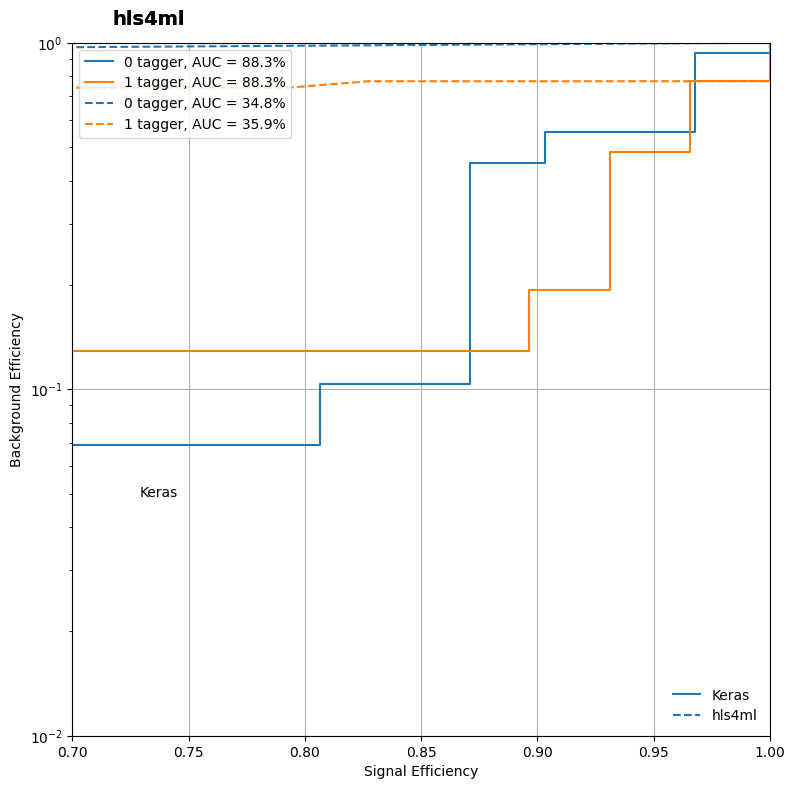

In [36]:
print(Y_test_reduced, y_predict_hls4ml)
plotROC(Y_test_reduced,y_predict,y_predict_hls4ml,label="Keras") 
#plotROC(Y_test_reduced,y_predict_q,y_predict_hls4ml_q,label="QKeras") 

Plot the pruned and quantized QKeras model<br>

Looks good! Let's synthesize the models. <br>
## Logic synthesis<br>
This takes quite a while for CNN models, up to one hour for the models considered here. In the interest of time, we have therefore provided the neccessary reports for the models considered. You can also synthesize them yourself if you have time, and as usual follow the progress using ``tail -f pruned_cnn/vivado_hls.log`` and ``tail -f quantized_pruned_cnn/vivado_hls.log``.<br>


In[29]:

In [ ]:
synth = False # Only if you want to synthesize the models yourself (>1h per model) rather than look at the provided reports.
if synth:
    hls_model.build(csim=False, synth=True, vsynth=True)
    hls_model_q.build(csim=False, synth=True, vsynth=True)

We extract the latency from the C synthesis, namely the report in ```<project_dir>/myproject_prj/solution1/syn/report/myproject_csynth.rpt```. A more accurate latency estimate can be obtained from running cosim by passing ```hls_model.build(csim=False, synth=True, vsynth=True, cosim=True)``` ( = C/RTL cosimulation, synthesised HLS code is run on a simulator and tested on C test bench) but this takes a lot of time so we will skip it here.<br>
The resource estimates are obtained from the Vivado logic synthesis, and can be extracted from the report in ```<project_dir>/vivado_synth.rpt```. Let's fetch the most relevant numbers:

In[30]:

In [ ]:
def getReports(indir):
    data_ = {}
    
    report_vsynth = Path('{}/vivado_synth.rpt'.format(indir))
    report_csynth = Path('{}/myproject_prj/solution1/syn/report/myproject_csynth.rpt'.format(indir))
    
    if report_vsynth.is_file() and report_csynth.is_file():
        print('Found valid vsynth and synth in {}! Fetching numbers'.format(indir))
        
        # Get the resources from the logic synthesis report 
        with report_vsynth.open() as report:
            lines = np.array(report.readlines())
            data_['lut']     = int(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[2])
            data_['ff']      = int(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[2])
            data_['bram']    = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[2])
            data_['dsp']     = int(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[2])
            data_['lut_rel'] = float(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[5])
            data_['ff_rel']  = float(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[5])
            data_['bram_rel']= float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[5])
            data_['dsp_rel'] = float(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[5])
        
        with report_csynth.open() as report:
            lines = np.array(report.readlines())
            lat_line = lines[np.argwhere(np.array(['Latency (cycles)' in line for line in lines])).flatten()[0] + 3]
            data_['latency_clks'] = int(lat_line.split('|')[2])
            data_['latency_mus']  = float(lat_line.split('|')[2])*5.0/1000.
            data_['latency_ii']   = int(lat_line.split('|')[6])
    
    return data_

In[31]:

In [ ]:
from pathlib import Path
import pprint 

In [ ]:
data_pruned_ref = getReports('pruned_cnn')
data_quantized_pruned = getReports('quantized_pruned_cnn')

In [ ]:
print("\n Resource usage and latency: Pruned")
pprint.pprint(data_pruned_ref)
print("\n Resource usage and latency: Pruned + quantized")
pprint.pprint(data_quantized_pruned)

We see that the latency is of around 5 microseconds for both the quantized and the unquantized model, but that the resources are signifcantly reduced using QKeras.<br>
<br>
Congratulations! You have now reached the end of this notebook. If you have some spare time, you can have a look at the bonus exercise below, where you will learn how to perform a bayesian optimization over the QKeras quantizers in order to obtain an optimally heterogeneously quantized model.<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


# Bonus exercise: Automatic quantization with AutoQKeras<br>
<br>
In this bonus exercise, you will learn how to find the optimal heterogeneously quantized model using AutoQKeras.<br>
For more details, you can look at the [AutoQKeras notebook](https://github.com/google/qkeras/blob/master/notebook/AutoQKeras.ipynb). <br>
<br>
Let's first check the estimated energy consumption of the QKeras 6-bit model using QTools. By setting ```for_reference=True``` you can print out the unquantized model energy consumption and compare the two. Note that this only works for QKeras layers. 

In[32]:

In[33]:

In [ ]:
from qkeras import print_qstats
# for automatic quantization
import pprint
from qkeras.autoqkeras import *
from qkeras import *
from qkeras.utils import model_quantize

In [ ]:
from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from qkeras import quantized_bits
from qkeras import QDense, QActivation

In [ ]:
q = run_qtools.QTools(model, 
                      process="horowitz", 
                      source_quantizers=[quantized_bits(16, 5, 1)], 
                      is_inference=True, 
                      weights_path=None,
                      keras_quantizer="fp16",
                      keras_accumulator="fp16", 
                      for_reference=False)
q.qtools_stats_print()

In [ ]:
energy_dict = q.pe(
    weights_on_memory="fixed",
    activations_on_memory="fixed",
    min_sram_size=8*16*1024*1024,
    rd_wr_on_io=False)

get stats of energy distribution in each layer

In [ ]:
energy_profile = q.extract_energy_profile(
    qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(
    qtools_settings.cfg.include_energy, energy_dict)

In [ ]:
pprint.pprint(energy_profile)
print()

In [ ]:
print("Total energy: {:.6f} uJ".format(total_energy / 1000000.0))

Now, lets use AutoQKeras to find an optimally heterogeneously quantized model for us. For more details, check the AutoQKeras tutorial linked above. As baseline model, we'll use the pruned floating point Keras model from above.

In[34]:

These are the quantizers we'll test in the bayesian optimization

In [ ]:
quantization_config = {
        "kernel": {
                "quantized_bits(2,0,1,alpha=1.0)": 2,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(6,0,1,alpha=1.0)": 6,
                "quantized_bits(8,0,1,alpha=1.0)": 8,
        },
        "bias": {
                "quantized_bits(2,0,1,alpha=1.0)": 2,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(6,0,1,alpha=1.0)": 6,
                "quantized_bits(8,0,1,alpha=1.0)": 8,
        },
        "activation": {
                "quantized_relu(3,1)": 3,
                "quantized_relu(4,2)": 4,
                "quantized_relu(8,2)": 8,
                "quantized_relu(8,4)": 8,
                "quantized_relu(16,6)": 16
        },
        "linear": {
                "quantized_bits(2,0,1,alpha=1.0)": 2,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(6,0,1,alpha=1.0)": 6,
                "quantized_bits(8,0,1,alpha=1.0)": 8,
        }
}

These are the layer types we will quantize

In [ ]:
limit = {
    "Dense": [8, 8, 16],
    "Conv2D": [8, 8, 16],
    "Activation": [16],
}

Use this if you want to minimize the model bit size

In [ ]:
goal_bits = {
    "type": "bits",
          "params": {
              "delta_p": 8.0, # We tolerate up to a +8% accuracy change
              "delta_n": 8.0, # We tolerate down to a -8% accuracy change
              "rate": 2.0,    # We want a x2 times smaller model
              "stress": 1.0,  # Force the reference model size to be smaller by setting stress<1
              "input_bits": 8,
              "output_bits": 8,
              "ref_bits": 8,
              "config": {
                  "default": ["parameters", "activations"]
              }
          }
}

Use this if you want to minimize the model energy consumption

In [ ]:
goal_energy = {
    "type": "energy",
    "params": {
        "delta_p": 8.0,
        "delta_n": 8.0,
        "rate": 2.0,
        "stress": 1.0,
        "process": "horowitz",
        "parameters_on_memory": ["sram", "sram"],
        "activations_on_memory": ["sram", "sram"],
        "rd_wr_on_io": [False, False],
        "min_sram_size": [0, 0],
        "source_quantizers": ["fp32"],
        "reference_internal": "int8",
        "reference_accumulator": "int32"
        }
}

In [ ]:
run_config = {
        "goal": goal_energy,
        "quantization_config": quantization_config,
        "learning_rate_optimizer": False,
        "transfer_weights": False, # Randomely initialize weights
        "mode": "bayesian", # This can be bayesian,random,hyperband
        "seed": 42,
        "limit": limit,
        "tune_filters": "layer",
        "tune_filters_exceptions": "^output",
        "distribution_strategy": None,
        "max_trials": 5 # Let's just do 5 trials for this demonstrator, ideally you should do as many as possible
}

In[36]:

In [ ]:
from qkeras.autoqkeras import AutoQKeras

In [ ]:
autoqk = AutoQKeras(model, output_dir="autoq_cnn", metrics=["acc"], custom_objects={}, **run_config)
autoqk.fit(train_data, validation_data=val_data, epochs=1)

In [ ]:
aqmodel = autoqk.get_best_model()
print_qmodel_summary(aqmodel)   

Train for the full epochs

In [ ]:
callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            ]  

In [ ]:
start = time.time()
history = aqmodel.fit(train_data,
                      epochs = n_epochs,
                      validation_data = val_data,
                      callbacks = callbacks, 
                      verbose=1)     
end = time.time()
print('\n It took {} minutes to train!\n'.format( (end - start)/60.))

In[37]:

This model has some remnants from the optimization procedure attached to it, so let's define a new one

In [ ]:
aqmodel.save_weights("autoqkeras_cnn_weights.h5")

In [ ]:
layers = [l for l in aqmodel.layers]
x = layers[0].output
for i in range(1, len(layers)):
    x = layers[i](x)

In [ ]:
new_model = Model(inputs=[layers[0].input], outputs=[x])   
LOSS        = tf.keras.losses.BinaryCrossentropy()
OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=3E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

In [ ]:
new_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])
new_model.summary()
new_model.load_weights("autoqkeras_cnn_weights.h5")
print_qmodel_summary(new_model)  

Let's check what the best heterogeneously quantized model looks like (keep in mind we only did a few trials, the optimization obviosuly didn't have time to converge at the minimum but yo get the idea!)

In[38]:

In [ ]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

In [ ]:
hls_config_aq = hls4ml.utils.config_from_keras_model(new_model, granularity='name')
hls_config_aq['Model']['ReuseFactor'] = 1
hls_config_aq['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config_aq['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config_aq)
  
cfg_aq = hls4ml.converters.create_config(backend='Vivado')
cfg_aq['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg_aq['HLSConfig']  = hls_config_aq
cfg_aq['KerasModel'] = new_model
cfg_aq['OutputDir']  = 'autoqkeras_cnn/'
cfg_aq['XilinxPart'] = 'xcu250-figd2104-2L-e'
  
hls_model_aq = hls4ml.converters.keras_to_hls(cfg_aq)
hls_model_aq.compile()

In[40]:

In [ ]:
y_predict_aq        = aqmodel.predict(X_test_reduced)
y_predict_hls4ml_aq = hls_model_aq.predict(np.ascontiguousarray(X_test_reduced))

In [ ]:
accuracy_keras  = float(accuracy_score (np.argmax(Y_test_reduced,axis=1), np.argmax(y_predict_aq,axis=1)))
accuracy_hls4ml = float(accuracy_score (np.argmax(Y_test_reduced,axis=1), np.argmax(y_predict_hls4ml_aq,axis=1)))

In [ ]:
print("Accuracy AutoQ Keras:  {}".format(accuracy_keras))
print("Accuracy AutoQ hls4ml: {}".format(accuracy_hls4ml))
    

The accuracy is slightly lower for this heterogeneously quantized model. Due to some randomness in the optimization procedure, you're going to have to synthesize this one yourself!

In[41]:

In [ ]:
synth = False
if synth:
    hls_model_aq.build(csim=False, synth=True, vsynth=True)
    data_autoq = getReports('autoq_cnn')
    print("\n Resource usage and latency: AutoQ")
    pprint.pprint(data_autoq)

In[ ]: